In [2]:
import random
import numpy as np
from importlib import reload
import mido
import IPython.display as ipd
import pretty_midi

import scales

In [68]:
class Note:
    def __init__(self, pitch, octave, duration, velocity):
        self.pitch = pitch
        self.octave = octave
        self.duration = duration
        self.velocity = velocity

def generator(notes, pitch_weights=None, octave_weights=None, duration_weights=None, length=1, tpb=480, 
              duration='fixed', velocity = 'fixed', 
              sd=0.064, rest_probability=0.16):
    if pitch_weights is None:
        pitch_weights = {note: 1 for note in notes}  # set all weights to 1 if not specified
    if octave_weights is None:
        octave_weights = {octave: 1 for octave in range(0, 9)}  # set all weights to 1 if not specified

    # dur = tpb
    durations = tpb*np.logspace(-5, 2, num=8, base=2) # duration of the note from 1/32 to 4
    if duration_weights is None:
        duration_weights = {duration: 1 for duration in durations}  # set all weights to 1 if not specified

    vel = 64
    sequence = []
    for _ in range(length):
        # Choose a random octave between 0 and 8
        octave = random.choices(range(0, 9), weights=octave_weights)[0]
        # Choose a random note from the given notes with the given weights
        pitch = random.choices(notes, weights=pitch_weights)[0]
        dur = random.choices(durations, weights=duration_weights)[0]
        # Check for variables
        if duration == 'variable':
            dur = int(random.normalvariate(dur, dur * sd))
        if velocity == 'variable':
            vel = int(random.normalvariate(64, 64 * sd))
        # Introduce rests with a certain probability
        if random.random() < rest_probability:
            sequence.append(Note(pitch=0, octave=0, duration=dur, velocity=0))
        else:
            # Add the chosen note to the sequence
            sequence.append(Note(pitch=pitch, octave=octave, duration=dur, velocity=vel))

    midi_notes = []

    for n in sequence:
        note_on = mido.Message('note_on', note=n.pitch + (n.octave * 12), 
                               velocity=n.velocity, time=0)
        midi_notes.append(note_on)
        note_off = mido.Message('note_off', note=n.pitch + (n.octave * 12), 
                                velocity=n.velocity, time=n.duration)
        midi_notes.append(note_off)

    return sequence, midi_notes

reload(scales)
scale = scales.chromatic    # choose a scale
scale_name = 'chromatic'

tpb = 480  # ticks per beat
length = 50  # length of the sequence
sd = 0.16  # standard deviation of the duration and velocity
rp = 0.24  # rest probability
tempo = mido.bpm2tempo(140) # tempo beats per minute
pitch_weights = None  # set all weights to 1 if not specified
octave_weights = None  # set all weights to 1 if not specified
duration_weights = None  # set all weights to 1 if not specified

track_count = 4  # number of tracks to generate

# Create a separate track (track 0) for tempo changes
mid = mido.MidiFile(ticks_per_beat=tpb)
tempo_track = mido.MidiTrack()
mid.tracks.append(tempo_track)
tempo_track.append(mido.MetaMessage('set_tempo', tempo=tempo))

for i in range(track_count):
    track = mido.MidiTrack()
    # track.name = track_names[i] # assign the track name
    mid.tracks.append(track)
    sequence, midi_notes = generator(scale['notes'], pitch_weights=pitch_weights, 
                                     octave_weights=octave_weights,
                                     length=length, tpb=tpb, duration='variable', 
                                     velocity='variable',
                                     sd=sd, rest_probability=rp)
    # Add the note events to the MIDI track
    for note in midi_notes:
        track.append(note)

# Write the MIDI file to disk
midi_path = f'generated/{scale_name}_tracks_{track_count}.mid'
mid.save(midi_path)
# Load the MIDI file using pretty_midi
midi_data = pretty_midi.PrettyMIDI(midi_path)
# Synthesize the MIDI file into a waveform
audio_data = midi_data.synthesize(fs=44100)
# Normalize the audio data
audio_data /= np.max(np.abs(audio_data))
# Play the audio data in the Jupyter notebook
ipd.Audio(audio_data, rate=44100)

[  15.   30.   60.  120.  240.  480.  960. 1920.]


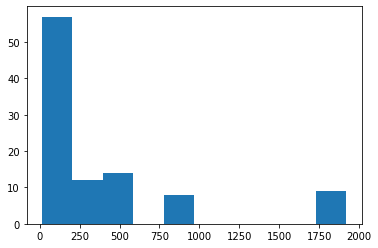

In [91]:
durations = tpb*np.logspace(-5, 2, num=8, base=2) # duration of the note from 1/32 to 4
duration_weights = [[0,0,0,1,2,1,0,0], [0,0,0,1,2,1,0,0], 
                    [1,1,1,1,1,1,1,1], [0,1,2,1,1,1,0,0], [0,1,2,1,1,1,0,0]]
rand = random.choices(durations, weights=duration_weights[2], k=100)
print(durations)
import matplotlib.pyplot as plt
plt.hist(rand, bins=10)
plt.show()


In [92]:
import generator
import scales
reload(generator)
reload(scales)
from generator import generator

length = 150  # length of the sequence
tpb = 480  # ticks per beat
sd = 0.016  # standard deviation of the duration and velocity
rp = 0.16  # rest probability
mid = mido.MidiFile(ticks_per_beat=tpb)

tempo = mido.bpm2tempo(140) # tempo beats per minute
# Create a separate track (track 0) for tempo changes
tempo_track = mido.MidiTrack()
mid.tracks.append(tempo_track)
tempo_track.append(mido.MetaMessage('set_tempo', tempo=tempo))

song_name = 'comb_test'

track_list = ['bass_1', 'bass_2', 'melody_1', 'melody_2', 'melody_3']
comb = {c: {} for c in track_list}
scale_list = [scales.minor_pentatonic['notes'], scales.minor_pentatonic['notes'],
              scales.minor_pentatonic['notes'], scales.minor_11_arpeggio['notes'], 
              scales.minor_9_arpeggio['notes']]
pitch_weights = [[2,1,1,1.5,1], [2,1,1,1.5,1], None, None, None]
octave_weights = [[1,1,2,1,0,0,0,0,0], [0,1,2,1,1,0,0,0,0], 
                  [0,0,0,1,2,1,1,0,0], [0,0,0,0,0,1,1,1,1], [0,0,0,1,1,2,1,0,0]]
duration_weights = [[0,0,0,1,2,1,0,0], [0,0,0,1,2,1,0,0], 
                    [1,1,1,1,1,1,1,1], [0,1,2,1,1,1,0,0], [0,1,2,1,1,1,0,0]]

# add pitch and octave weights to comb dict
for i,c in enumerate(comb):
    comb[c]['pitch_weights'] = pitch_weights[i]
    comb[c]['octave_weights'] = octave_weights[i]
    comb[c]['duration_weights'] = duration_weights[i]
    comb[c]["scale"] = scale_list[i]


for i, c in enumerate(comb.values()):
    track = mido.MidiTrack()
    mid.tracks.append(track)
    track.name = track_list[i] # assign the track name
    sequence, midi_notes = generator(c["scale"], pitch_weights=c['pitch_weights'],
                                    octave_weights=c['octave_weights'], duration_weights=c['duration_weights'],
                                     length=length, tpb=tpb, duration='variable', 
                                        velocity='variable',
                                     sd=sd, rest_probability=rp)
    # Add the note events to the MIDI track
    for note in midi_notes:
        track.append(note)

# Write the MIDI file to disk
midi_path = f'generated/{song_name}_tracks_{len(comb)}.mid'
mid.save(midi_path)
# Load the MIDI file using pretty_midi
midi_data = pretty_midi.PrettyMIDI(midi_path)
# Synthesize the MIDI file into a waveform
audio_data = midi_data.synthesize(fs=44100)
# Normalize the audio data
audio_data /= np.max(np.abs(audio_data))
# Play the audio data in the Jupyter notebook
ipd.Audio(audio_data, rate=44100)

# optionl - open in GarageBand or DAW of choice
import subprocess
subprocess.call(['open', '-a', 'GarageBand', midi_path])

0